In [9]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Question 4

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
            
    train = pd.DataFrame(train)    
    test = pd.DataFrame(test)   
    
    for feature in train.columns:
        if train[feature].nunique() == 1:
            train.drop(feature, axis=1)
            test.drop(feature, axis=1)
            
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    
    train = (train - min_val) / (max_val - min_val)
    test = (test - min_val) / (max_val - min_val)
    
    return np.array(train), np.array(test)

In [3]:
def load_data():
    #Loading the dataset
    print('loading the dataset')

    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


### Question 8

In [4]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    
    loss = (1 / X.shape[0]) * np.sum((X @ theta - y)**2)
    
    return loss

### Question 9

In [68]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    
    grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y)
    
    return grad 

### Question 10

In [69]:
#Getting the gradient calculation correct is often the trickiest part of any gradient-based optimization algorithm. 
#Fortunately, it's very easy to check that the gradient calculation is correct using the definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    I = np.identity(theta.shape[0])
    
    for i in range(0, num_features):
        approx_grad[i] = (compute_square_loss(X, y, theta + epsilon * I[:,i]) - compute_square_loss(X, y, theta - epsilon * I[:,i]))/(2*epsilon)
    distance = np.sqrt(np.sum((true_gradient - approx_grad)**2))
    
    return distance
    if distance < tolerance: 
        return True #There is no major difference between gradients
    else:
        return False #There is a major difference between gradients

In [70]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, 
                             epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. 
    And check whether gradient_func(X, y, theta) returned the true 
    gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    #TODO

### Question 11

In [71]:
def batch_grad_descent(X, y, alpha=0.1, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.zeros(num_features)  #Initialize theta
    
    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0] = theta
    for i in range(1, num_step+1):
    
        theta = theta - alpha * compute_square_loss_gradient(X, y, theta)
            
        loss = compute_square_loss(X, y, theta)
        loss_hist[i] = loss
        theta_hist[i] = theta
        
    return theta_hist, loss_hist

### Question 12

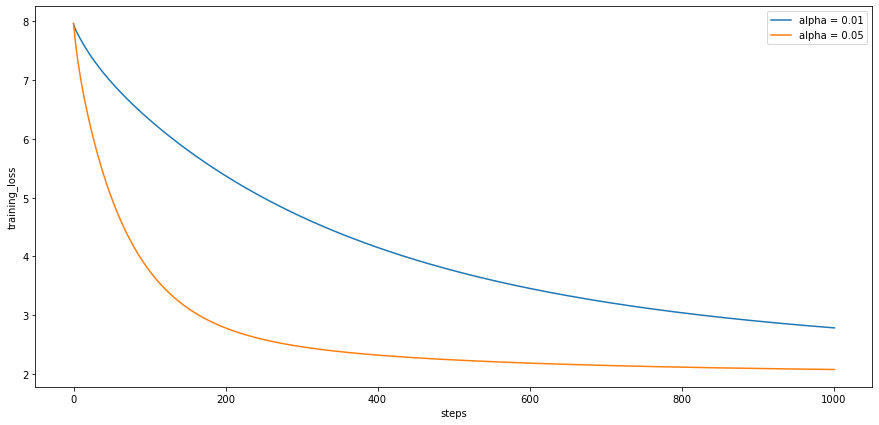

In [72]:
x = np.linspace(0, 1001, 1001)

plt.figure(figsize=(15,7))

theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.01, num_step=1000, grad_check=False)
sns.lineplot(x=x, y=loss_hist, label='alpha = 0.01')

theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.05, num_step=1000, grad_check=False)
sns.lineplot(x=x, y=loss_hist, label='alpha = 0.05')

#theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.5, num_step=1000, grad_check=False)
#sns.lineplot(x=x, y=theta_hist[:,0], label='alpha = 0.5')

#theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.1, num_step=1000, grad_check=False)
#sns.lineplot(x=x, y=theta_hist[:,0], label='alpha = 0.5')

plt.xlabel('steps')
plt.ylabel('training_loss')
plt.show()

The step sizes 0.01 and 0.05 converge but 0.1 and 0.5 diverge.
Additionally, we can see that the minimum loss is around 2.

### Question 13

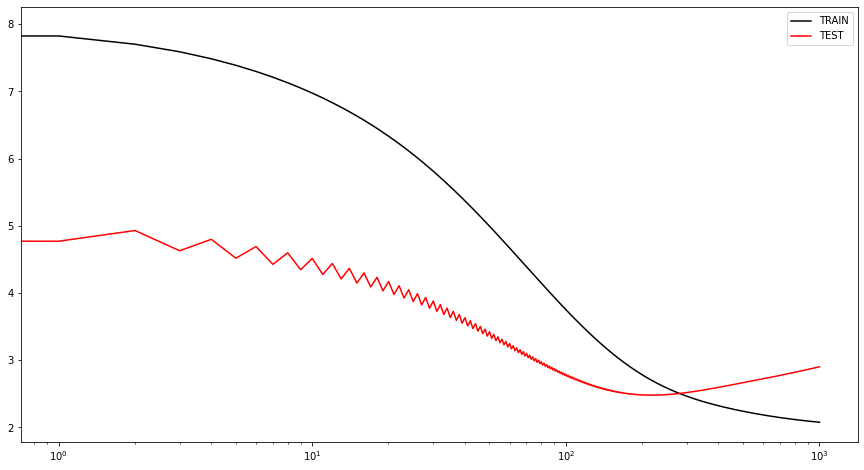

In [73]:
plt.figure(figsize=(15,8))

theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=0.05, num_step=1000, grad_check=False)

test_loss = []
for i in range(len(theta_hist)):
    test_loss.append(compute_square_loss(X_test, y_test, theta_hist[i]))

plt.xscale('log')   
plt.plot(x, loss_hist, label='TRAIN', color='black')
plt.plot(x, test_loss, label='TEST', color='red')
plt.legend()
plt.show()

### Question 15

In [74]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y) + 2 * lambda_reg * theta
    
    return grad 

### Question 16

In [75]:
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist

    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0] = theta
    for i in range(1, num_step+1):
    
        theta = theta - alpha * compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        loss = compute_square_loss(X, y, theta)
        loss_hist[i] = loss
        theta_hist[i] = theta
        
    return theta_hist, loss_hist

### Question 17

In [76]:
def plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg):

    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=lambda_reg, num_step=1000)
    test_loss = []
    for i in range(len(theta_hist)):
        test_loss.append(compute_square_loss(X_test, y_test, theta_hist[i]))

    return test_loss

C:\Users\alexx\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/325647661.py:14: RuntimeWarning: overflow encountered in square
  loss = (1 / X.shape[0]) * np.sum((X @ theta - y)**2)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2209270210.py:14: RuntimeWarning: overflow encountered in matmul
  grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y) + 2 * lambda_reg * theta
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/325647661.py:14: RuntimeWarning: invalid value encountered in matmul
  loss = (1 / X.shape[0]) * np.sum((X @ theta - y)**2)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2209270210.py:14: RuntimeWarning: overflow encountered in multiply
  grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y) + 2 * lambda_reg * theta
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2214137038.py:24: RuntimeWarning: inval

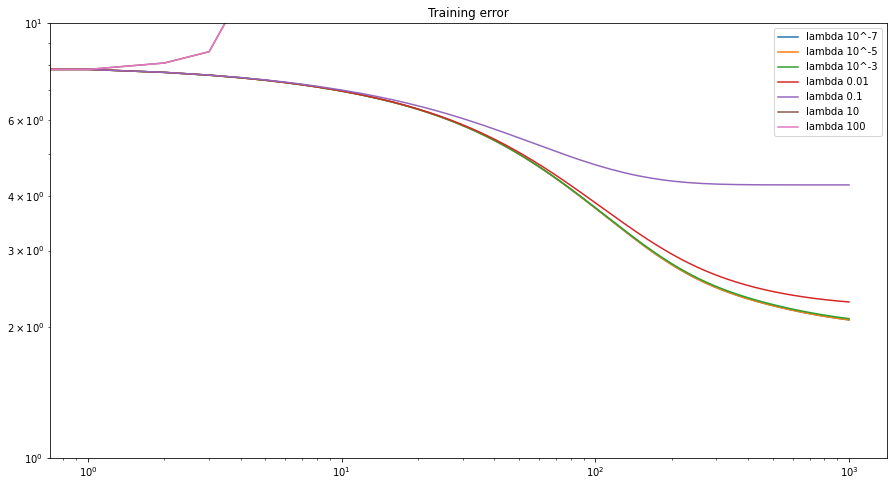

In [77]:
plt.figure(figsize=(15,8))

theta_hist, loss_hist_1 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-7, num_step=1000)
theta_hist, loss_hist_2 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-5, num_step=1000)
theta_hist, loss_hist_3 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10**-3, num_step=1000)
theta_hist, loss_hist_4 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=0.01, num_step=1000)
theta_hist, loss_hist_5 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=0.1, num_step=1000)
theta_hist, loss_hist_6 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=10, num_step=1000)
theta_hist, loss_hist_7 = regularized_grad_descent(X_train, y_train, alpha=0.05, lambda_reg=100, num_step=1000)

sns.lineplot(x=x, y=loss_hist_1, label='lambda 10^-7')
sns.lineplot(x=x, y=loss_hist_2, label='lambda 10^-5')
sns.lineplot(x=x, y=loss_hist_3, label='lambda 10^-3')
sns.lineplot(x=x, y=loss_hist_4, label='lambda 0.01')
sns.lineplot(x=x, y=loss_hist_5, label='lambda 0.1')
sns.lineplot(x=x, y=loss_hist_6, label='lambda 10')
sns.lineplot(x=x, y=loss_hist_6, label='lambda 100')

plt.xscale('log')
plt.yscale('log')
plt.title('Training error')
plt.show()

C:\Users\alexx\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/325647661.py:14: RuntimeWarning: overflow encountered in square
  loss = (1 / X.shape[0]) * np.sum((X @ theta - y)**2)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2209270210.py:14: RuntimeWarning: overflow encountered in matmul
  grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y) + 2 * lambda_reg * theta
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/325647661.py:14: RuntimeWarning: invalid value encountered in matmul
  loss = (1 / X.shape[0]) * np.sum((X @ theta - y)**2)
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2209270210.py:14: RuntimeWarning: overflow encountered in multiply
  grad = (2 / X.shape[0]) * (X.T @ X @ theta - X.T @ y) + 2 * lambda_reg * theta
C:\Users\alexx\AppData\Local\Temp/ipykernel_5948/2214137038.py:24: RuntimeWarning: inval

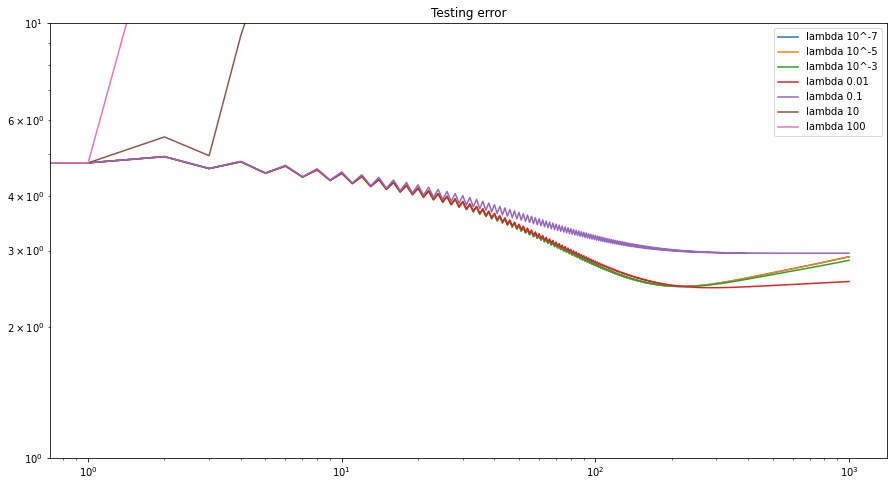

In [78]:
plt.figure(figsize=(15,8))

test_loss_1 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=10**-7)
test_loss_2 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=10**-5)
test_loss_3 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=10**-3)
test_loss_4 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=0.01)
test_loss_5 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=0.1)
test_loss_6 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=10)
test_loss_7 = plot_test_loss(X_train, y_train, X_test, y_test, lambda_reg=100)

sns.lineplot(x=x, y=test_loss_1, label='lambda 10^-7')
sns.lineplot(x=x, y=test_loss_2, label='lambda 10^-5')
sns.lineplot(x=x, y=test_loss_3, label='lambda 10^-3')
sns.lineplot(x=x, y=test_loss_4, label='lambda 0.01')
sns.lineplot(x=x, y=test_loss_5, label='lambda 0.1')
sns.lineplot(x=x, y=test_loss_6, label='lambda 10')
sns.lineplot(x=x, y=test_loss_7, label='lambda 100')

plt.xscale('log')
plt.yscale('log'),
plt.title('Testing error')
plt.show()

Overfitting consists on the training error being very low and the testing error being high, meaning that the training data was memorized and therefore the model fails to generalize. In this case, we can see that around step 400, the testing error starts increasing while the training error keeps going down, that when overfitting starts.

### Question 18

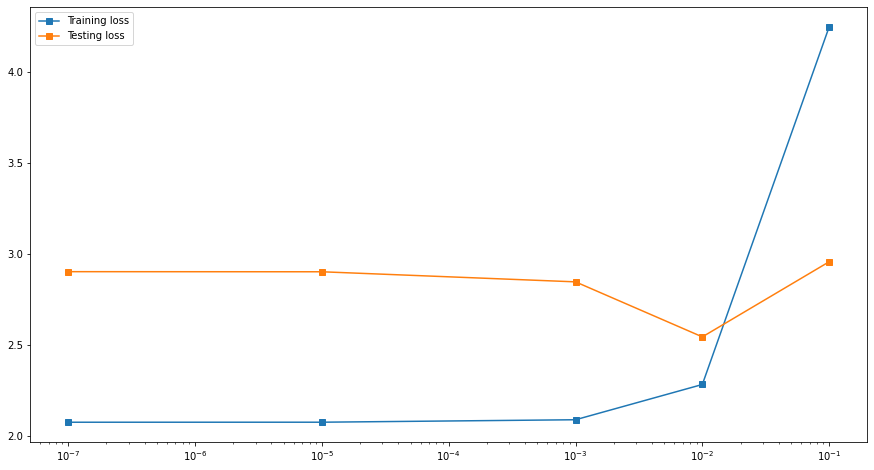

In [79]:
plt.figure(figsize=(15,8))

a = [loss_hist_1[-1], loss_hist_2[-1], loss_hist_3[-1], loss_hist_4[-1], loss_hist_5[-1]]
b = [test_loss_1[-1], test_loss_2[-1], test_loss_3[-1], test_loss_4[-1], test_loss_5[-1]]
lambdas = [10**-7, 10**-5, 10**-3, 0.01, 0.1]

plt.plot(lambdas, a, label='Training loss', marker='s')
plt.plot(lambdas, b, label='Testing loss', marker='s')
plt.xscale('log')
plt.legend()
plt.show()

The best lambda would be where the training error intersects the testing error. Therefore, out of these lambdas I would choose lambda=0.01

### Question 19

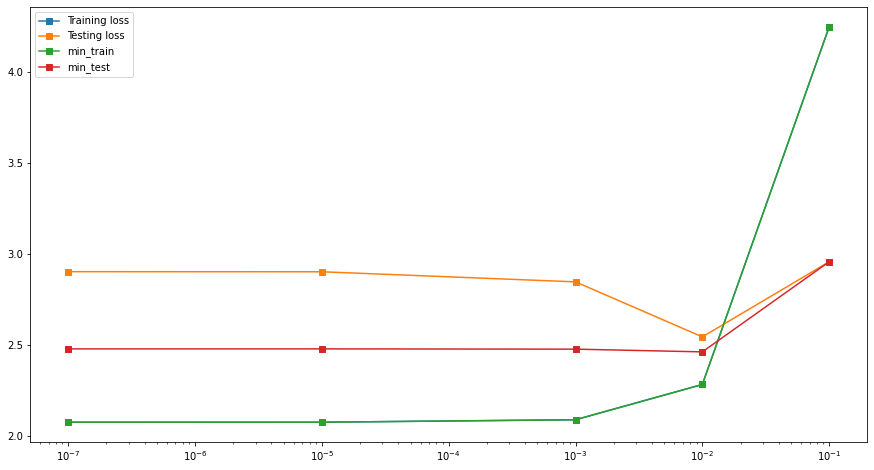

In [80]:
plt.figure(figsize=(15,8))

a = [loss_hist_1[-1], loss_hist_2[-1], loss_hist_3[-1], loss_hist_4[-1], loss_hist_5[-1]]
b = [test_loss_1[-1], test_loss_2[-1], test_loss_3[-1], test_loss_4[-1], test_loss_5[-1]]
min_a = [min(loss_hist_1), min(loss_hist_2), min(loss_hist_3), min(loss_hist_4), min(loss_hist_5)]
min_b = [min(test_loss_1), min(test_loss_2), min(test_loss_3), min(test_loss_4), min(test_loss_5)]
lambdas = [10**-7, 10**-5, 10**-3, 0.01, 0.1]

plt.plot(lambdas, a, label='Training loss', marker='s')
plt.plot(lambdas, b, label='Testing loss', marker='s')
plt.plot(lambdas, min_a, label='min_train', marker='s')
plt.plot(lambdas, min_b, label='min_test', marker='s')
plt.xscale('log')
plt.legend()
plt.show()

Now, the diference between testing errors is much lower so it does not matter as much but it does seem like the best lambda is still 0.01

Additionally, due to the fact that the training error always decreases, the minimum loss in training error is the same as the last training error (the green and blue line overlap).

### Question 20

In practice, I would choose the theta that minimizes the test loss. In this case that is when alpha is 0.05, lambda is 0.01 and we use early stopping.

### Question 24

In [60]:
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_epoch, num_instances, num_features)) #Initialize theta_hist
    loss_hist = np.zeros((num_epoch, num_instances)) #Initialize loss_hist
    np.random.seed(27)
    
    for epoch in range(0, num_epoch):
        
        #random_index = np.random.choice(list(range(0, len(X))), len(X), replace=False)
        random_index = np.random.permutation(num_instances)
        for i in range(0, len(random_index)): 
            
            #Save the historical loss and thetas
            loss_hist[epoch, i] = compute_square_loss(X, y, theta) + lambda_reg * theta.T @ theta
            theta_hist[epoch, i] = theta
            
            X_temp = X[random_index[i]].reshape(1,49)
            y_temp = y[random_index[i]].reshape(1,1)
            theta = theta.reshape(49,1)
            
            grad = 2 * (X_temp.T @ X_temp @ theta - (X_temp.T @ y_temp)) + 2 * lambda_reg * theta
            
            grad = grad.reshape(49,)
            theta = theta.reshape(49,)
            
            t = epoch * 100 + i+1
            #Check alpha
            if alpha == "1/sqrt(t)": 
                theta = theta - 0.1/np.sqrt(t) * grad
            elif alpha == "1/t":
                theta = theta - 0.1/t * grad
            else: 
                theta = theta - alpha * grad        
            
    return theta_hist, loss_hist

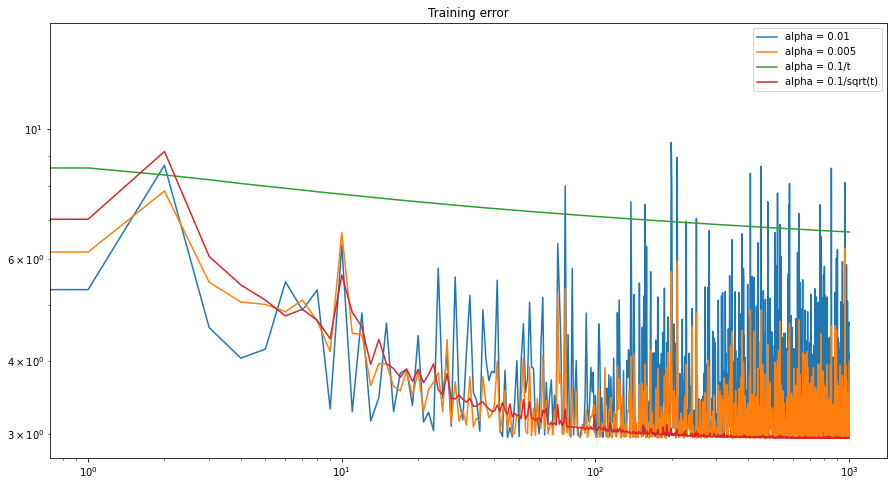

In [61]:
plt.figure(figsize=(15,8))
x = np.linspace(0, 1000, 1000)

theta_hist1, loss_hist1 = stochastic_grad_descent(X_train, y_train, alpha=0.01, lambda_reg=10**-2, num_epoch=1000)
theta_hist2, loss_hist2 = stochastic_grad_descent(X_train, y_train, alpha=0.005, lambda_reg=10**-2, num_epoch=1000)
theta_hist3, loss_hist3 = stochastic_grad_descent(X_train, y_train, alpha="1/t", lambda_reg=10**-2, num_epoch=1000)
theta_hist4, loss_hist4 = stochastic_grad_descent(X_train, y_train, alpha="1/sqrt(t)", lambda_reg=10**-2, num_epoch=1000)
theta_hist5, loss_hist5 = stochastic_grad_descent(X_train, y_train, alpha="1/sqrt(t)", lambda_reg=10**-2, num_epoch=1000)

sns.lineplot(x=x, y=loss_hist1[:,-1], label='alpha = 0.01')
sns.lineplot(x=x, y=loss_hist2[:,-1], label='alpha = 0.005')
sns.lineplot(x=x, y=loss_hist3[:,-1], label='alpha = 0.1/t')
sns.lineplot(x=x, y=loss_hist4[:,-1], label='alpha = 0.1/sqrt(t)')

plt.xscale('log')
plt.yscale('log')
plt.title('Training error')
plt.show()

### Question 25

It is clear that when the step size is constant there is much moire noise. Additionally, using a step size of C/sqrt(t) appears to be the best alpha.

### Question 28

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [4]:
def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

In [5]:
def classification_error(clf, X, y):
    return (np.sum(abs(clf.predict(X) - y))) / (2*X.shape[0])

In [6]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=1)
clf.fit(X_train, y_train)

test = classification_error(clf, X_test, y_test)
train = classification_error(clf, X_train, y_train)
print('train: ', train, end='\t')
print('test: ', test)

-- Epoch 1
Norm: 0.69, NNZs: 285, Bias: -0.000103, T: 9902, Avg. loss: 0.042221
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 258, Bias: -0.000385, T: 19804, Avg. loss: 0.031941
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 243, Bias: -0.000354, T: 29706, Avg. loss: 0.030154
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 0.88, NNZs: 228, Bias: -0.000183, T: 39608, Avg. loss: 0.029316
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 0.92, NNZs: 222, Bias: 0.000069, T: 49510, Avg. loss: 0.028678
Total training time: 0.20 seconds.
-- Epoch 6
Norm: 0.96, NNZs: 214, Bias: 0.000375, T: 59412, Avg. loss: 0.028264
Total training time: 0.25 seconds.
-- Epoch 7
Norm: 0.99, NNZs: 208, Bias: 0.000711, T: 69314, Avg. loss: 0.027940
Total training time: 0.29 seconds.
-- Epoch 8
Norm: 1.01, NNZs: 202, Bias: 0.001072, T: 79216, Avg. loss: 0.027635
Total training time: 0.33 seconds.
Convergence after 8 epochs took 0.33 seconds
train:  0.00222177337911533	test

### Question 29

In [7]:
mean_list, std_list = [], []
alpha_list = np.logspace(-4,-1, 10)


for alpha in alpha_list: 

    clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, penalty='l1', alpha=alpha, 
                        learning_rate='invscaling', power_t=0.5, eta0=0.01, verbose=1)

    error_list = []
    for _ in range(0, 10): 
        X_train, y_train = sub_sample(100, X_train, y_train)
        clf.fit(X_train, y_train)

        error_list.append(classification_error(clf, X_test, y_test))

    mean_list.append(np.mean(error_list))
    std_list.append(np.std(error_list))

-- Epoch 1
Norm: 0.30, NNZs: 494, Bias: 0.001060, T: 100, Avg. loss: 0.168085
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 552, Bias: 0.002648, T: 200, Avg. loss: 0.074592
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 607, Bias: 0.003557, T: 300, Avg. loss: 0.059215
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 607, Bias: 0.004228, T: 400, Avg. loss: 0.051216
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 606, Bias: 0.004734, T: 500, Avg. loss: 0.046016
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 606, Bias: 0.005161, T: 600, Avg. loss: 0.042263
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 607, Bias: 0.005506, T: 700, Avg. loss: 0.039392
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 607, Bias: 0.005817, T: 800, Avg. loss: 0.037084
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 605, Bias: 0.006085, T: 900, Avg. loss: 0.035178
Total training tim

Norm: 0.38, NNZs: 491, Bias: 0.001852, T: 300, Avg. loss: 0.058290
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 497, Bias: 0.002266, T: 400, Avg. loss: 0.050631
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 498, Bias: 0.002603, T: 500, Avg. loss: 0.045619
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 496, Bias: 0.002884, T: 600, Avg. loss: 0.041968
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 499, Bias: 0.003112, T: 700, Avg. loss: 0.039161
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 498, Bias: 0.003319, T: 800, Avg. loss: 0.036894
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.44, NNZs: 498, Bias: 0.003493, T: 900, Avg. loss: 0.035021
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.45, NNZs: 496, Bias: 0.003652, T: 1000, Avg. loss: 0.033435
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.45, NNZs: 496, Bias: 0.003796, T: 1100, Avg. loss: 0.032062
Total training time: 0.01

-- Epoch 11
Norm: 0.44, NNZs: 605, Bias: 0.014216, T: 1100, Avg. loss: 0.031436
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.45, NNZs: 551, Bias: 0.014373, T: 1200, Avg. loss: 0.030240
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.45, NNZs: 550, Bias: 0.014516, T: 1300, Avg. loss: 0.029184
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.46, NNZs: 549, Bias: 0.014648, T: 1400, Avg. loss: 0.028241
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 0.46, NNZs: 545, Bias: 0.014769, T: 1500, Avg. loss: 0.027390
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 0.47, NNZs: 541, Bias: 0.014883, T: 1600, Avg. loss: 0.026618
Total training time: 0.01 seconds.
-- Epoch 17
Norm: 0.47, NNZs: 533, Bias: 0.014993, T: 1700, Avg. loss: 0.025915
Total training time: 0.01 seconds.
-- Epoch 18
Norm: 0.48, NNZs: 532, Bias: 0.015096, T: 1800, Avg. loss: 0.025271
Total training time: 0.01 seconds.
Convergence after 18 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.29, NNZs: 607, 

Norm: 0.41, NNZs: 507, Bias: 0.015305, T: 600, Avg. loss: 0.042605
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 500, Bias: 0.015557, T: 700, Avg. loss: 0.039768
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 499, Bias: 0.015780, T: 800, Avg. loss: 0.037481
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 493, Bias: 0.015976, T: 900, Avg. loss: 0.035595
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.44, NNZs: 490, Bias: 0.016143, T: 1000, Avg. loss: 0.033998
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.44, NNZs: 488, Bias: 0.016303, T: 1100, Avg. loss: 0.032612
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.45, NNZs: 488, Bias: 0.016442, T: 1200, Avg. loss: 0.031404
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.45, NNZs: 486, Bias: 0.016574, T: 1300, Avg. loss: 0.030333
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.46, NNZs: 484, Bias: 0.016697, T: 1400, Avg. loss: 0.029373
Total training time

Norm: 0.44, NNZs: 413, Bias: 0.006263, T: 700, Avg. loss: 0.041614
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 411, Bias: 0.006462, T: 800, Avg. loss: 0.039278
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.46, NNZs: 410, Bias: 0.006631, T: 900, Avg. loss: 0.037351
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.46, NNZs: 410, Bias: 0.006784, T: 1000, Avg. loss: 0.035709
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.47, NNZs: 409, Bias: 0.006924, T: 1100, Avg. loss: 0.034290
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.47, NNZs: 409, Bias: 0.007052, T: 1200, Avg. loss: 0.033047
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.48, NNZs: 408, Bias: 0.007168, T: 1300, Avg. loss: 0.031940
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.48, NNZs: 409, Bias: 0.007283, T: 1400, Avg. loss: 0.030952
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 0.49, NNZs: 409, Bias: 0.007381, T: 1500, Avg. loss: 0.030056
Total training ti

Norm: 0.30, NNZs: 491, Bias: 0.010083, T: 100, Avg. loss: 0.166432
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 479, Bias: 0.011612, T: 200, Avg. loss: 0.074347
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 470, Bias: 0.012564, T: 300, Avg. loss: 0.059421
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 467, Bias: 0.013208, T: 400, Avg. loss: 0.051609
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 460, Bias: 0.013717, T: 500, Avg. loss: 0.046520
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 455, Bias: 0.014124, T: 600, Avg. loss: 0.042847
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 450, Bias: 0.014478, T: 700, Avg. loss: 0.040024
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 449, Bias: 0.014786, T: 800, Avg. loss: 0.037753
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 446, Bias: 0.015044, T: 900, Avg. loss: 0.035873
Total training time: 0.01 sec

Norm: 0.40, NNZs: 414, Bias: 0.011082, T: 500, Avg. loss: 0.049318
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 412, Bias: 0.011449, T: 600, Avg. loss: 0.045581
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 410, Bias: 0.011781, T: 700, Avg. loss: 0.042658
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 409, Bias: 0.012055, T: 800, Avg. loss: 0.040308
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.44, NNZs: 407, Bias: 0.012303, T: 900, Avg. loss: 0.038370
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.45, NNZs: 407, Bias: 0.012533, T: 1000, Avg. loss: 0.036710
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.45, NNZs: 406, Bias: 0.012736, T: 1100, Avg. loss: 0.035291
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.46, NNZs: 403, Bias: 0.012927, T: 1200, Avg. loss: 0.034044
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.46, NNZs: 402, Bias: 0.013100, T: 1300, Avg. loss: 0.032941
Total training time: 

Norm: 0.30, NNZs: 448, Bias: 0.011450, T: 100, Avg. loss: 0.155971
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 434, Bias: 0.012851, T: 200, Avg. loss: 0.073617
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 428, Bias: 0.013571, T: 300, Avg. loss: 0.059770
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 422, Bias: 0.014107, T: 400, Avg. loss: 0.052293
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 418, Bias: 0.014502, T: 500, Avg. loss: 0.047381
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 416, Bias: 0.014826, T: 600, Avg. loss: 0.043821
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 414, Bias: 0.015114, T: 700, Avg. loss: 0.041062
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 414, Bias: 0.015366, T: 800, Avg. loss: 0.038820
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 414, Bias: 0.015590, T: 900, Avg. loss: 0.036988
Total training time: 0.00 sec

Norm: 0.35, NNZs: 393, Bias: 0.004525, T: 200, Avg. loss: 0.076984
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 391, Bias: 0.005566, T: 300, Avg. loss: 0.062328
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 389, Bias: 0.006398, T: 400, Avg. loss: 0.054528
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 387, Bias: 0.007060, T: 500, Avg. loss: 0.049521
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.42, NNZs: 386, Bias: 0.007611, T: 600, Avg. loss: 0.045896
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.43, NNZs: 383, Bias: 0.008066, T: 700, Avg. loss: 0.043139
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 381, Bias: 0.008480, T: 800, Avg. loss: 0.040913
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.44, NNZs: 378, Bias: 0.008850, T: 900, Avg. loss: 0.039088
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.45, NNZs: 376, Bias: 0.009178, T: 1000, Avg. loss: 0.037541
Total training time: 0.01 s

Norm: 0.38, NNZs: 389, Bias: 0.007423, T: 400, Avg. loss: 0.057859
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 385, Bias: 0.007999, T: 500, Avg. loss: 0.052515
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 385, Bias: 0.008472, T: 600, Avg. loss: 0.048732
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 382, Bias: 0.008880, T: 700, Avg. loss: 0.045822
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 379, Bias: 0.009240, T: 800, Avg. loss: 0.043476
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.44, NNZs: 378, Bias: 0.009571, T: 900, Avg. loss: 0.041542
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.44, NNZs: 376, Bias: 0.009878, T: 1000, Avg. loss: 0.039889
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.45, NNZs: 374, Bias: 0.010150, T: 1100, Avg. loss: 0.038449
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.46, NNZs: 372, Bias: 0.010403, T: 1200, Avg. loss: 0.037202
Total training time: 0.

-- Epoch 10
Norm: 0.48, NNZs: 351, Bias: 0.004176, T: 1000, Avg. loss: 0.043641
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.49, NNZs: 347, Bias: 0.004506, T: 1100, Avg. loss: 0.042420
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.50, NNZs: 346, Bias: 0.004815, T: 1200, Avg. loss: 0.041387
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.50, NNZs: 345, Bias: 0.005107, T: 1300, Avg. loss: 0.040453
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.51, NNZs: 343, Bias: 0.005384, T: 1400, Avg. loss: 0.039662
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 0.51, NNZs: 343, Bias: 0.005648, T: 1500, Avg. loss: 0.038884
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 0.52, NNZs: 340, Bias: 0.005900, T: 1600, Avg. loss: 0.038237
Total training time: 0.01 seconds.
-- Epoch 17
Norm: 0.52, NNZs: 338, Bias: 0.006143, T: 1700, Avg. loss: 0.037654
Total training time: 0.01 seconds.
Convergence after 17 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.32, NNZs: 384, 

-- Epoch 2
Norm: 0.36, NNZs: 326, Bias: 0.009507, T: 200, Avg. loss: 0.099124
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 319, Bias: 0.010893, T: 300, Avg. loss: 0.083721
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.41, NNZs: 316, Bias: 0.011944, T: 400, Avg. loss: 0.075938
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.43, NNZs: 312, Bias: 0.012809, T: 500, Avg. loss: 0.070785
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.44, NNZs: 308, Bias: 0.013566, T: 600, Avg. loss: 0.067634
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 303, Bias: 0.014237, T: 700, Avg. loss: 0.065048
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 297, Bias: 0.014850, T: 800, Avg. loss: 0.063308
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.48, NNZs: 296, Bias: 0.015418, T: 900, Avg. loss: 0.061534
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.49, NNZs: 293, Bias: 0.015944, T: 1000, Avg. loss: 0.060398
Total training t

-- Epoch 8
Norm: 0.46, NNZs: 307, Bias: 0.022221, T: 800, Avg. loss: 0.065712
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.47, NNZs: 301, Bias: 0.022717, T: 900, Avg. loss: 0.064050
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.48, NNZs: 299, Bias: 0.023183, T: 1000, Avg. loss: 0.062674
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.49, NNZs: 298, Bias: 0.023611, T: 1100, Avg. loss: 0.061608
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 0.50, NNZs: 294, Bias: 0.024022, T: 1200, Avg. loss: 0.060410
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 0.50, NNZs: 291, Bias: 0.024413, T: 1300, Avg. loss: 0.059610
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 0.51, NNZs: 288, Bias: 0.024782, T: 1400, Avg. loss: 0.058881
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 0.52, NNZs: 288, Bias: 0.025131, T: 1500, Avg. loss: 0.058181
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 0.53, NNZs: 284, Bias: 0.025473, T: 1600, Avg. loss: 0.057457
Tota

Norm: 0.39, NNZs: 304, Bias: 0.012452, T: 100, Avg. loss: 0.208537
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.43, NNZs: 284, Bias: 0.014926, T: 200, Avg. loss: 0.130747
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.46, NNZs: 267, Bias: 0.016621, T: 300, Avg. loss: 0.118752
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.48, NNZs: 259, Bias: 0.018060, T: 400, Avg. loss: 0.112658
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.50, NNZs: 250, Bias: 0.019263, T: 500, Avg. loss: 0.109673
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.52, NNZs: 243, Bias: 0.020345, T: 600, Avg. loss: 0.106516
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.53, NNZs: 238, Bias: 0.021311, T: 700, Avg. loss: 0.104641
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.55, NNZs: 237, Bias: 0.022193, T: 800, Avg. loss: 0.103124
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.56, NNZs: 232, Bias: 0.023017, T: 900, Avg. loss: 0.101805
Total training time: 0.01 sec

Norm: 0.37, NNZs: 243, Bias: 0.004762, T: 100, Avg. loss: 0.269819
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.42, NNZs: 213, Bias: 0.008057, T: 200, Avg. loss: 0.214901
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.46, NNZs: 201, Bias: 0.010729, T: 300, Avg. loss: 0.207151
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 187, Bias: 0.012904, T: 400, Avg. loss: 0.201255
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.51, NNZs: 179, Bias: 0.014781, T: 500, Avg. loss: 0.198004
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.53, NNZs: 171, Bias: 0.016455, T: 600, Avg. loss: 0.195247
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.55, NNZs: 161, Bias: 0.017975, T: 700, Avg. loss: 0.192725
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.57, NNZs: 160, Bias: 0.019377, T: 800, Avg. loss: 0.191311
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.58, NNZs: 153, Bias: 0.020652, T: 900, Avg. loss: 0.189496
Total training time: 0.01 sec

Norm: 0.65, NNZs: 115, Bias: 0.035814, T: 1700, Avg. loss: 0.177603
Total training time: 0.01 seconds.
-- Epoch 18
Norm: 0.66, NNZs: 115, Bias: 0.036622, T: 1800, Avg. loss: 0.176863
Total training time: 0.01 seconds.
-- Epoch 19
Norm: 0.67, NNZs: 113, Bias: 0.037412, T: 1900, Avg. loss: 0.176323
Total training time: 0.01 seconds.
-- Epoch 20
Norm: 0.68, NNZs: 108, Bias: 0.038179, T: 2000, Avg. loss: 0.175824
Total training time: 0.01 seconds.
-- Epoch 21
Norm: 0.69, NNZs: 106, Bias: 0.038925, T: 2100, Avg. loss: 0.175206
Total training time: 0.01 seconds.
Convergence after 21 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.33, NNZs: 221, Bias: 0.016265, T: 100, Avg. loss: 0.274634
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.39, NNZs: 190, Bias: 0.019442, T: 200, Avg. loss: 0.213178
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.43, NNZs: 176, Bias: 0.021995, T: 300, Avg. loss: 0.203092
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.46, NNZs: 163, Bias: 0.023946, T:

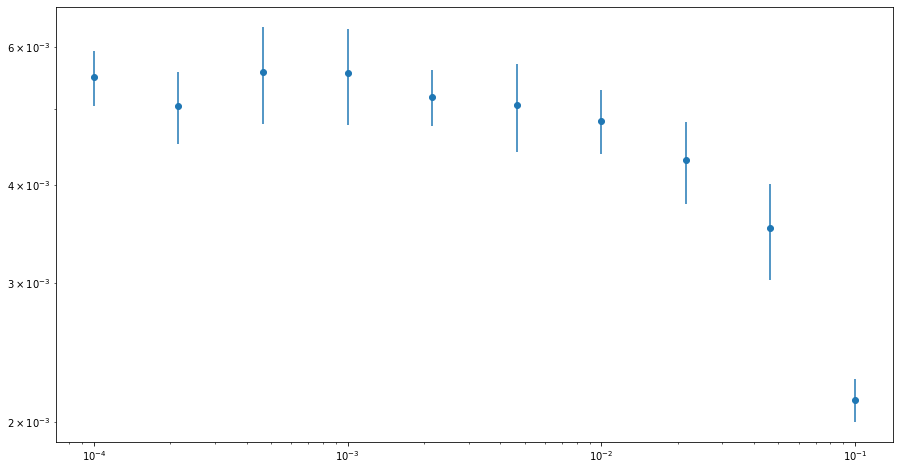

In [10]:
plt.figure(figsize = (15,8))

plt.errorbar(alpha_list,mean_list,yerr = std_list, fmt = 'o')

plt.yscale("log")
plt.xscale('log')
plt.show()

### Question 30

The sole source of randomness comes from the selection of the subset of data.

### Question 31

The optimal value of the parameter alpha is 0.1, it has the lowest test error mean as seen in the graph.

### Question 32

In [27]:
clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0, 
                        learning_rate='invscaling', power_t=0.5, eta0=0.01)
clf.fit(X_train, y_train)
coeffs = clf.coef_.reshape(28,28)

In [34]:
clf_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, penalty='l1', alpha=0.05, 
                       learning_rate='invscaling', power_t=0.5, eta0=0.01)
clf_reg.fit(X_train, y_train)
coeffs_reg = clf_reg.coef_.reshape(28,28)

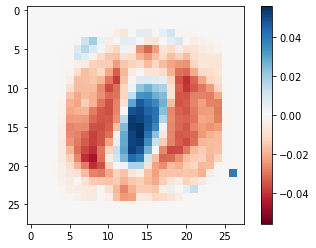

In [35]:
scale = np.abs(clf.coef_).max()
plt.imshow(coeffs, cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
plt.colorbar()
plt.show()

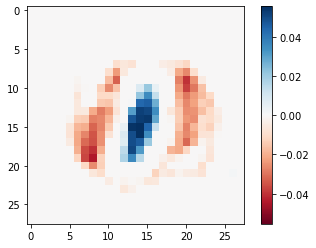

In [36]:
scale = np.abs(clf_reg.coef_).max()
plt.imshow(coeffs_reg, cmap=plt.cm.RdBu, vmax=scale, vmin=-scale)
plt.colorbar()
plt.show()

The pattern of coefficients reflect the pixels of the image, we can see that the value is lower (red) when the pixel is assigned to the target 0 and higher (blue) when it is assigned to the target 1.<br>

Additionallty, the regularization turns the less informative coefficients to 0 and therefore they are not seen in the second graph.<br>